In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
%pylab inline

import tensorflow as tf
from tensorflow.contrib.integrate import odeint, odeint_fixed

Populating the interactive namespace from numpy and matplotlib


In [2]:
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
IMAGE_SHAPE = [28, 28, 1]

In [3]:
import gzip, zipfile, tarfile
import os, shutil, re, string, urllib, fnmatch
import pickle as pkl

def _download_mnist_realval(dataset):
    """
    Download the MNIST dataset if it is not present.
    :return: The train, test and validation set.
    """
    origin = (
        'http://www.iro.umontreal.ca/~lisa/deep/data/mnist/mnist.pkl.gz'
    )
    print('Downloading data from %s' % origin)
    urllib.request.urlretrieve(origin, dataset)

def _get_datafolder_path():
    full_path = os.path.abspath('.')
    path = full_path +'/data'
    return path

def load_mnist_realval(
        dataset=_get_datafolder_path()+'/mnist_real/mnist.pkl.gz'):
    '''
    Loads the real valued MNIST dataset
    :param dataset: path to dataset file
    :return: None
    '''
    if not os.path.isfile(dataset):
        datasetfolder = os.path.dirname(dataset)
        if not os.path.exists(datasetfolder):
            os.makedirs(datasetfolder)
        _download_mnist_realval(dataset)

    f = gzip.open(dataset, 'rb')
    train_set, valid_set, test_set = pkl.load(f, encoding='latin1')
    f.close()
    x_train, targets_train = train_set[0], train_set[1]
    x_valid, targets_valid = valid_set[0], valid_set[1]
    x_test, targets_test = test_set[0], test_set[1]
    return x_train, targets_train, x_valid, targets_valid, x_test, targets_test

In [4]:
x_train, targets_train, x_valid, targets_valid, x_test, targets_test = load_mnist_realval()

In [5]:
len(x_train)

50000

In [6]:
x1 = np.zeros((len(x_train), 32,32,1))
x1[:,:28,:28,0] = x_train.reshape((-1, 28,28))
x_train = x1

In [134]:
x1 = np.zeros((len(x_test), 32,32,1))
x1[:,:28,:28,0] = x_test.reshape((-1, 28,28))
x_test = x1

In [7]:
from functools import partial

In [8]:
from tensorflow.python.framework import constant_op
class Squeeze2d(tfb.Reshape):
    """
    Borrowed from https://github.com/openai/glow/blob/master/tfops.py
    """
    
    def __init__(self,
                 event_shape_in,
                 factor=2,
                 is_constant_jacobian=True,
                 validate_args=False,
                 name=None):

        assert factor >= 1
        name = name or "squeeze"
        self.factor = factor
        event_shape_out = 1*event_shape_in
        event_shape_out[0] //=2
        event_shape_out[1] //=2
        event_shape_out[2] *=4
        
        super(Squeeze2d, self).__init__(
            event_shape_out=event_shape_out,
            event_shape_in=event_shape_in,
        validate_args=validate_args,
        name=name)
        
    
    def _forward(self, x):
        
        if self.factor == 1:
            return x
        shape = x.get_shape()
        height = int(shape[1])
        width = int(shape[2])
        n_channels = int(shape[3])
        assert height % self.factor == 0 and width % self.factor == 0
        x = tf.reshape(x, [-1, height//self.factor, self.factor,
                           width//self.factor, self.factor, n_channels])
        x = tf.transpose(x, [0, 1, 3, 5, 2, 4])
        x = tf.reshape(x, [-1, height//self.factor, width //
                           self.factor, n_channels*self.factor*self.factor])
        return x

    def _inverse(self, x):
        if self.factor == 1:
            return x
        shape = x.get_shape()
        height = int(shape[1])
        width = int(shape[2])
        n_channels = int(shape[3])
        assert n_channels >= 4 and n_channels % 4 == 0
        x = tf.reshape(
            x, (-1, height, width, int(n_channels/self.factor**2), self.factor, self.factor))
        x = tf.transpose(x, [0, 1, 4, 2, 5, 3])
        x = tf.reshape(x, (-1, int(height*self.factor),
                           int(width*self.factor), int(n_channels/self.factor**2)))
        return x

In [25]:
# Define the flow
def func(y, t, name):
    shape = y.shape
    with tf.variable_scope('network_%s'%name, reuse=tf.AUTO_REUSE):
        y = tf.layers.conv2d(y, shape[-1]//2 +1, 3,activation=tf.nn.leaky_relu,padding='same')
        y = tf.layers.conv2d(y, shape[-1], 3, activation=tf.nn.leaky_relu,padding='same')
    return y

def inv_func(y,t,name):
    return -func(y,t,name)

In [84]:
class ODENet(tfb.Bijector):

    def __init__(self,
       h=1.0,
       dt=0.01,
       is_constant_jacobian=True,
       validate_args=False,
       name=None):
        self.h = h
        self.dt = dt
        name = name or "revnet"
        super(ODENet, self).__init__(
        forward_min_event_ndims=3,
        is_constant_jacobian=is_constant_jacobian,
        validate_args=validate_args,
        name=name)
        
    def _forward(self, x):
        net = odeint_fixed(partial(func, name=self.name), x, array([0, self.h]).astype('float32'), dt=self.dt)[-1]
        return net
    
    def _inverse(self, x):
        net = odeint_fixed(partial(inv_func, name=self.name), x, array([0, self.h]).astype('float32'), dt=self.dt)[-1]
        return net

    def _inverse_log_det_jacobian(self, y):
        return constant_op.constant(0., x.dtype.base_dtype)

    def _forward_log_det_jacobian(self, x):       
        return constant_op.constant(0., x.dtype.base_dtype)

In [239]:
tf.reset_default_graph()
batch_size = 128

lr = tf.placeholder_with_default(0.001,shape=[])
x = tf.placeholder(shape=[batch_size, 32,32, 1],dtype=tf.float32)
dt = tf.cast(tf.placeholder_with_default(0.01,shape=[]), dtype=tf.float64)

In [240]:
c1 = [
     ODENet(name='layer3', h=0.3),
     Squeeze2d(event_shape_in=[4,4,64]),
     ODENet(name='layer2', h=0.3),
     Squeeze2d(event_shape_in=[8,8,16]),  
     ODENet(name='layer1', h=0.3),
     Squeeze2d(event_shape_in=[16,16,4])
     ]

chain1 = tfb.Chain(c1)

In [241]:
rep = chain1.forward(x)

In [242]:
rec = chain1.inverse(1.*rep+0.)

In [243]:
mask = np.ones((batch_size, 4,4,64))
mask[:,:,:,16:] = 0
projection = chain1.inverse(rep*mask)

In [244]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [245]:
yo,r,p = sess.run([rep,rec,projection], feed_dict={x:x_train[0:batch_size]})

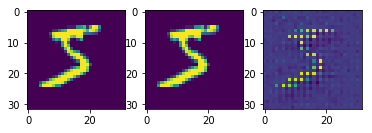

In [248]:
subplot(131)
imshow(x_train[0,:,:,0])
subplot(132)
imshow(r[0,:,:,0])
subplot(133)
imshow(p[0,:,:,0])

In [250]:
loss = tf.reduce_mean(tf.reduce_sum(rep[...,16:]**2,axis=[1,2,3])) + tf.reduce_mean(tf.reduce_sum((projection - x)**2,axis=[1,2,3]))

In [251]:
optimizer = tf.train.AdamOptimizer(learning_rate=0.001)

In [252]:
opt_op = optimizer.minimize(loss)

In [253]:
sess = tf.Session()

In [254]:
sess.run(tf.global_variables_initializer())

In [255]:
inds = choice(len(x_train),batch_size)
c,p,t = sess.run([rep,projection,x],feed_dict={x: x_train[inds], lr:0.001})

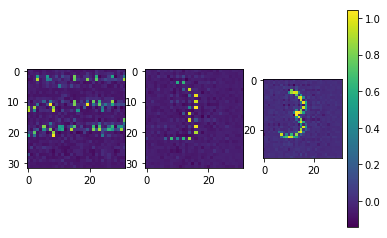

In [256]:
subplot(131)
imshow(c[0].reshape((32,32)))
subplot(132)
imshow(p[0].reshape((32,32)))
subplot(133)
imshow((t[0] -p[0]).reshape((32,32))); colorbar()

In [257]:
losses = []
losses_samp = []

In [294]:
nepochs=1000
for ep in range(nepochs):
    inds = choice(len(x_train),batch_size)
    _, l, c,r  = sess.run([opt_op, loss,rep,rec],
                            feed_dict={x: x_train[inds], lr:0.001})
    losses.append(l)
    if ep % 10 == 0:
        print(l)

11.96161
12.681325
12.089189
11.903273
11.594384
11.391288
11.671362
11.259055
10.786541
11.170677
11.318743
11.320387
10.799168
10.903711
10.664168
10.491684
10.646495
10.463958
10.605301
10.454495
10.208281
9.967934
10.271412
10.328346
9.646034
10.251646
10.230815
9.395582
9.93736
10.036917
8.980373
9.297443
9.5692835
9.077015
9.347853
9.442232
9.387406
9.076269
9.166401


KeyboardInterrupt: 

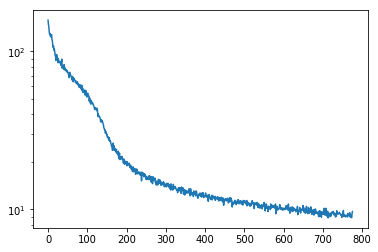

In [295]:
plot(losses)
yscale('log')

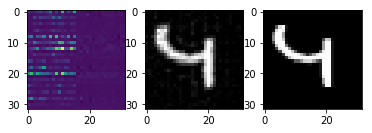

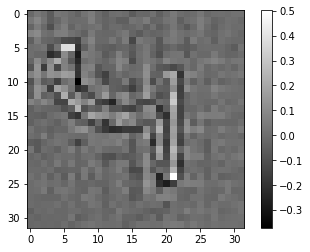

In [298]:
inds = choice(len(x_test),batch_size)
labels = targets_test[inds]
c,r,t,p = sess.run([rep,rec,x,projection],feed_dict={x: x_test[inds], lr:0.001})
subplot(131)
imshow(c[0].reshape((32,32)));
subplot(132)
imshow(p[0].reshape((32,32)),vmin=0,vmax=1,cmap='gray')
subplot(133)
imshow(t[0].reshape((32,32)),cmap='gray');

figure()

imshow(r[0].reshape((32,32)) - p[0].reshape((32,32)), cmap='gray');colorbar()

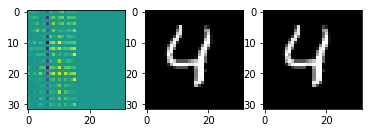

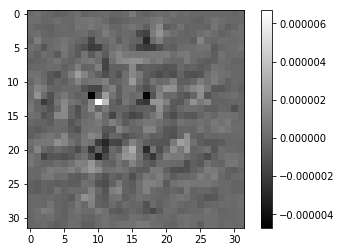

In [167]:
inds = choice(len(x_test),batch_size)
labels = targets_test[inds]
c,r,t = sess.run([rep,rec,x],feed_dict={x: x_test[inds], lr:0.001})
subplot(131)
imshow(c[0].reshape((32,32)));
subplot(132)
imshow(r[0].reshape((32,32)),vmin=0,vmax=1,cmap='gray')
subplot(133)
imshow(t[0].reshape((32,32)),cmap='gray');

figure()

imshow(r[0].reshape((32,32)) - t[0].reshape((32,32)), cmap='gray');colorbar()

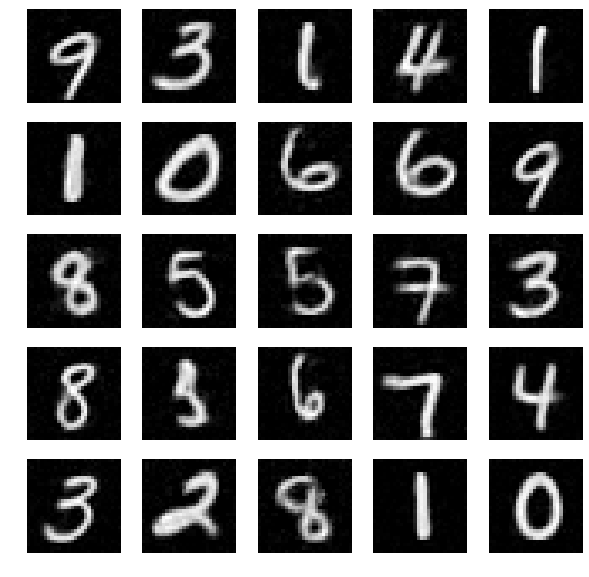

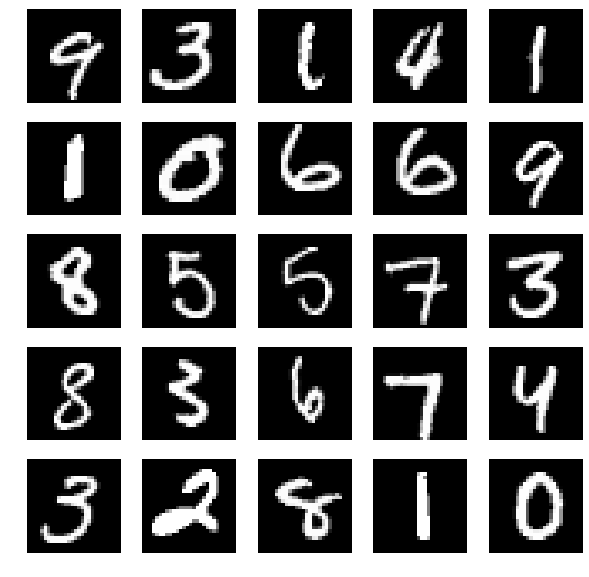

In [257]:
figure(figsize=(10,10))
for i in range(25):
    subplot(5,5,i+1)
    imshow(r[i].reshape(28,28),cmap='gray',vmin=0)
    axis('off')

figure(figsize=(10,10))
for i in range(25):
    subplot(5,5,i+1)
    imshow(t[i].reshape(28,28),cmap='gray')
    axis('off')

(-1, 1)

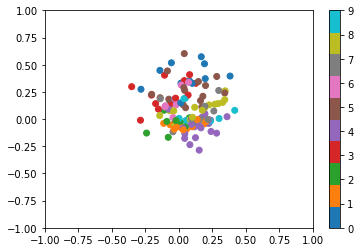

In [181]:
scatter(c[:,0],c[:,1],c=labels, cmap='tab10'); colorbar();
xlim(-1,1)
ylim(-1,1)

(-0.1, 0.1)

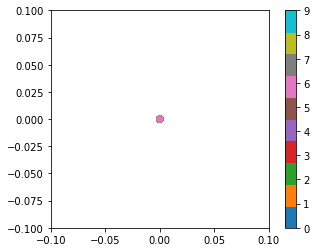

In [182]:
scatter(c[:,-1],c[:,-2],c=labels, cmap='tab10'); colorbar(); gca().set_aspect('equal')
xlim(-0.1,0.1)
ylim(-0.1,0.1)

In [47]:
c[:,-1]

array([-0., -0.,  0.,  0., -0.,  0., -0., -0., -0., -0.,  0., -0., -0.,
       -0.,  0., -0.,  0., -0.,  0., -0., -0., -0., -0., -0., -0., -0.,
       -0.,  0., -0., -0., -0., -0., -0., -0., -0.,  0., -0., -0.,  0.,
       -0., -0., -0.,  0., -0., -0.,  0., -0., -0., -0., -0., -0., -0.,
       -0., -0., -0., -0.,  0., -0., -0., -0., -0., -0., -0., -0., -0.,
       -0.,  0.,  0., -0., -0.,  0.,  0., -0.,  0.,  0., -0.,  0., -0.,
       -0.,  0., -0.,  0., -0., -0.,  0.,  0., -0., -0., -0., -0., -0.,
       -0., -0.,  0.,  0., -0.,  0., -0.,  0., -0., -0.,  0., -0.,  0.,
        0.,  0., -0., -0., -0.,  0., -0.,  0.,  0., -0., -0., -0.,  0.,
       -0., -0., -0., -0., -0., -0., -0.,  0., -0.,  0.,  0.],
      dtype=float32)

In [234]:
tf.trainable_variables()

[<tf.Variable 'network_0/dense/kernel:0' shape=(784, 512) dtype=float32_ref>,
 <tf.Variable 'network_0/dense/bias:0' shape=(512,) dtype=float32_ref>,
 <tf.Variable 'network_0/dense_1/kernel:0' shape=(512, 784) dtype=float32_ref>,
 <tf.Variable 'network_0/dense_1/bias:0' shape=(784,) dtype=float32_ref>,
 <tf.Variable 'network_1/dense/kernel:0' shape=(784, 512) dtype=float32_ref>,
 <tf.Variable 'network_1/dense/bias:0' shape=(512,) dtype=float32_ref>,
 <tf.Variable 'network_1/dense_1/kernel:0' shape=(512, 784) dtype=float32_ref>,
 <tf.Variable 'network_1/dense_1/bias:0' shape=(784,) dtype=float32_ref>,
 <tf.Variable 'network_2/dense/kernel:0' shape=(784, 512) dtype=float32_ref>,
 <tf.Variable 'network_2/dense/bias:0' shape=(512,) dtype=float32_ref>,
 <tf.Variable 'network_2/dense_1/kernel:0' shape=(512, 784) dtype=float32_ref>,
 <tf.Variable 'network_2/dense_1/bias:0' shape=(784,) dtype=float32_ref>,
 <tf.Variable 'network_3/dense/kernel:0' shape=(784, 512) dtype=float32_ref>,
 <tf.Varia